# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 97 kB 3.6 MB/s 
     |████████████████████████████████| 376 kB 57.5 MB/s 
     |████████████████████████████████| 58 kB 6.1 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=fa7f0e8e2c8eb54ff1ba48bd194592f293ef986f6e30281a790b82a3c8a6e7de
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=30721265cc239473531aed2bb4e4936a105531a1d5ddd6eada90bebc92477423
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning htt

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 15.02 MiB/s, done.
Resolving deltas: 100% (3/3), done.


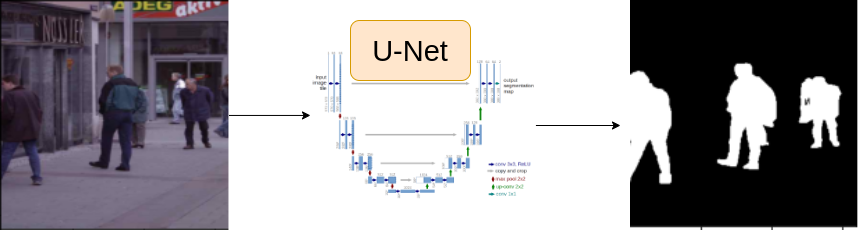

# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [5]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'

DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003
IMG_SIZE = 320

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenent'

In [6]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [7]:
row = df.iloc[4]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)/ 255

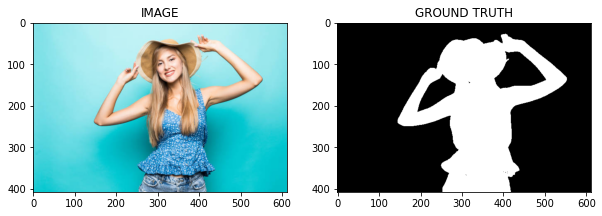

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [9]:
train_df , valid_df = train_test_split(df, test_size = 0.2, random_state = 42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [10]:
import albumentations as A

In [11]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
      A.HorizontalFlip(p = 0.5),
      A.VerticalFlip(p = 0.5)
  ])

def get_valid_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
      
  ])


# Task 4 : Create Custom Dataset 

In [12]:
from torch.utils.data import Dataset

In [13]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):

    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df) 

  def __getitem__(self, idx):

    row = self.df.iloc[idx] 

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)#(h, w, c)
    mask = np.expand_dims(mask, axis= -1)

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']

      #(h, w, c) -> (c, h, w)

    image = np.transpose(image,(2,0,1)).astype(np.float32)
    mask = np.transpose(mask,(2,0,1)).astype(np.float32) 

    image = torch.Tensor(image)/255
    mask = torch.round(torch.Tensor(mask)/255)

    return image, mask

In [14]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [15]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


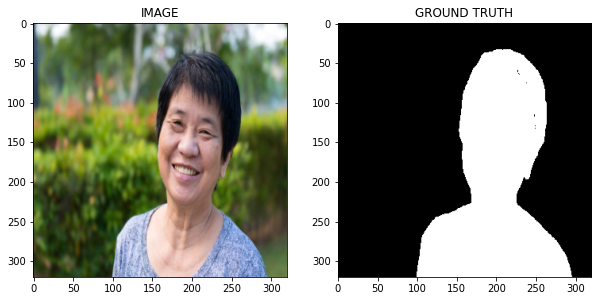

In [16]:
idx = 3

image, mask = trainset[idx]
helper.show_image(image , mask)

# Task 5 : Load dataset into batches

In [17]:
from torch.utils.data import DataLoader

In [18]:
trainloader = DataLoader(trainset, shuffle= True)
validloader = DataLoader(validset)

In [19]:
print(f"total no. of batches in trainloader :{len(trainloader)}")
print(f"total no. of batches in validloader :{len(validloader)}")

total no. of batches in trainloader :232
total no. of batches in validloader :58


In [20]:
for image, mask in trainloader:
  break
  print(f"One batch image shape  : {image.shape}")
  print(f"One batch mask shape  : {mask.shape}")

# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [21]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [22]:
class SegmentationModel(nn.Module):
   def __init__(self):
        super(SegmentationModel, self).__init__()
    
        self.arc = smp.Unet(
           encoder_name= ENCODER,
           encoder_weights= WEIGHTS,
           in_channels = 3,
           activation = None
    )

   def forward(self, images, mask = None):

     logits = self.arc(images)

     if  masks != None:
          loss1 = DiceLoss(mode='binary')(logits, masks)
          loss2 = nn.BCEWithLogitsLoss()(logits, masks)
          return logits, loss1 + loss2

     return logits  


In [23]:
from segmentation_models_pytorch import Unet
model = Unet()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

# Task 7 : Create Train and Validation Function 

In [25]:
from scipy import optimize
def train_fn(data_loader, model, optimizer):

  model.train()
  total_loss = 0.0
  for images,masks in data_loader:

    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimize.step()

    total_loss += loss.item()

  return total_loss / len(data_loader)   

In [26]:

def eval_fn(data_loader, model):

  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images,masks in data_loader:

        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        logits, loss = model(images, masks)
    

        total_loss += loss.item()

  return total_loss / len(data_loader)
   